# Conversational Threads

Many LLM applications have a chatbot-like interface in which the user and the LLM application engage in a multi-turn conversation. In order to track these conversations, you can use the Threads feature in LangSmith.

This is relevant to our RAG application, which should maintain context from prior conversations with users.

### Setup

In [3]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

### Group traces into threads


A Thread is a sequence of traces representing a single conversation. Each response is represented as its own trace, but these traces are linked together by being part of the same thread.

To associate traces together, you need to pass in a special metadata key where the value is the unique identifier for that thread.

The key value is the unique identifier for that conversation. The key name should be one of:

- session_id
- thread_id
- conversation_id.

The value should be a UUID.

In [4]:
import uuid
thread_id = uuid.uuid4()

In [5]:
from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the latest question in the conversation. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    """
    messages = [
        {
            "role": "system",
            "content": rag_system_prompt
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable(run_type="llm")
def call_openai(
    messages: List[dict], model: str = "gpt-4o-mini", temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )

@traceable(run_type="chain")
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


### Now let's run our application twice with this thread_id

In [7]:
question = "How do I add metadata to a Trace?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

To add metadata to a trace in LangSmith, you need to include a dictionary of key-value pairs when creating the trace. This metadata can store additional information about the trace, such as the environment or user details. Ensure that the same metadata is also attached to the corresponding run for better tracking.


In [8]:
question = "How can I add tags to a Trace?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

You can add tags to a trace in LangSmith by sending arbitrary metadata and tags along with the trace. Tags are strings used to categorize or label the trace, while metadata is a dictionary of key-value pairs for additional information. For detailed instructions, refer to the documentation on adding metadata and tags to traces.


### Let's take a look in LangSmith!

This is the most recent call in my langchain desktop. Here we can see that now we have an extra feild that is the "threads" in the upper right corner:

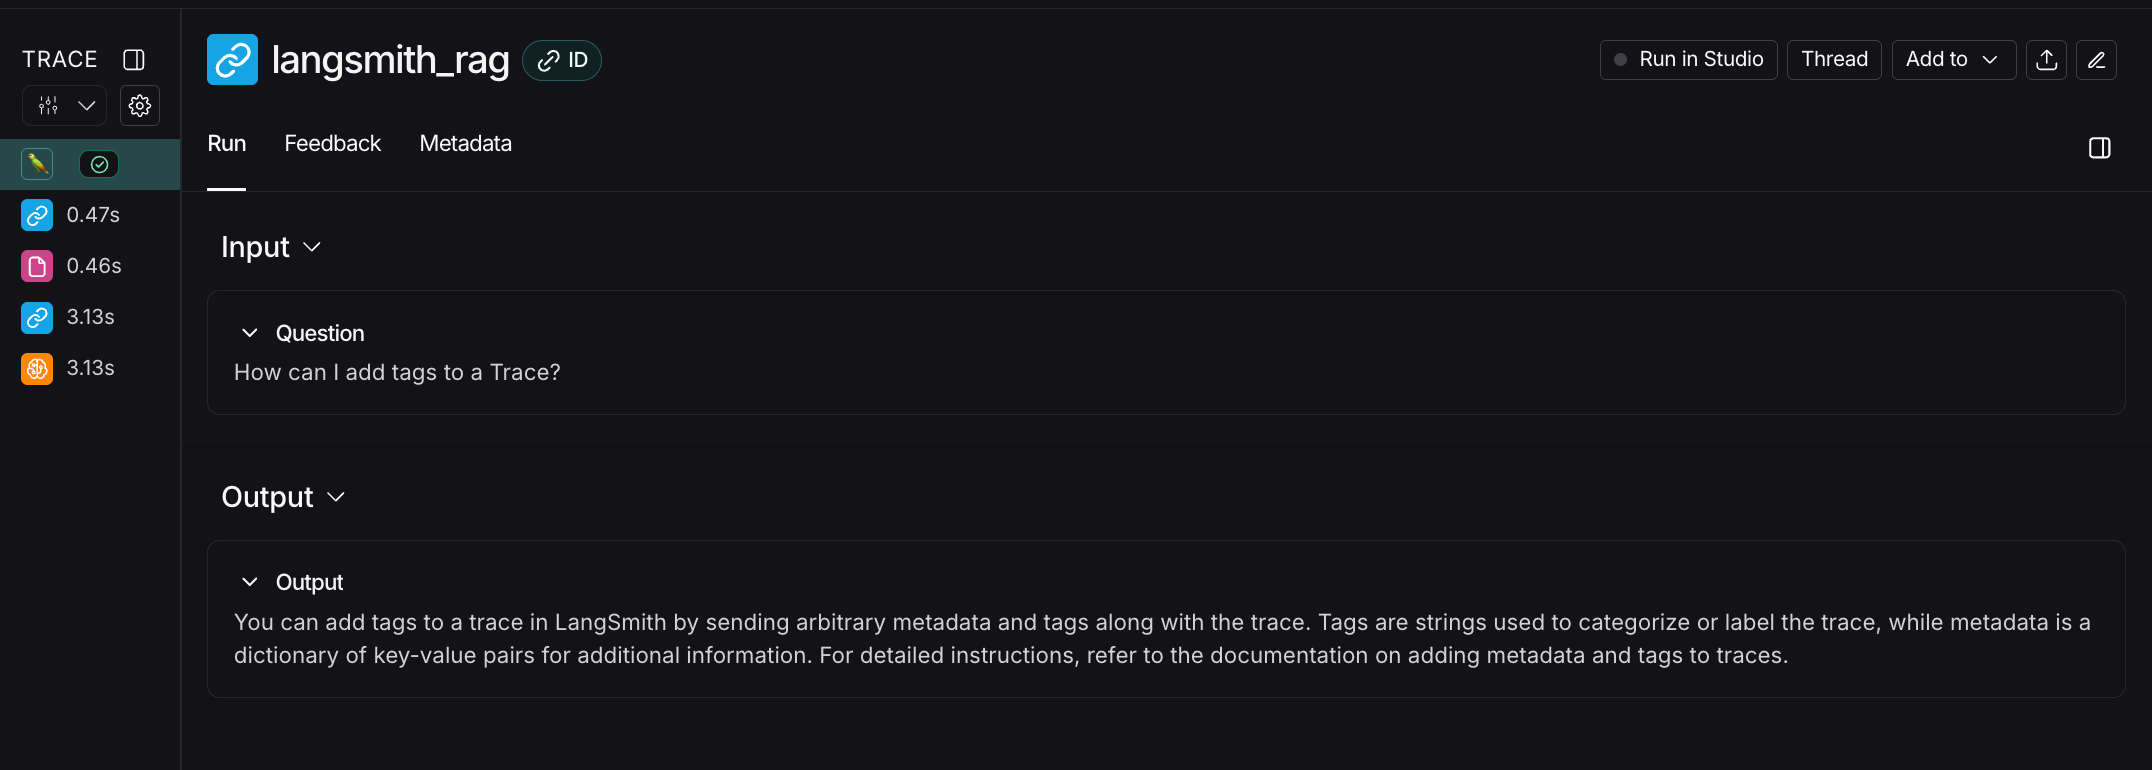

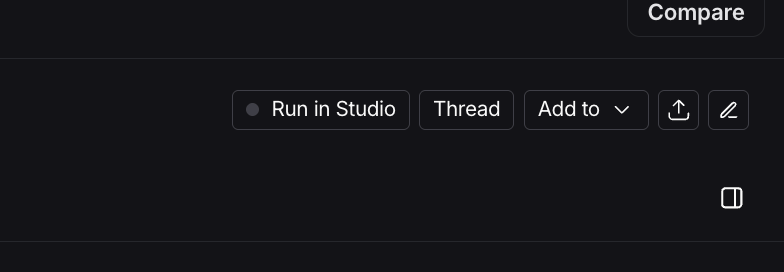

The thread id in the metadata:

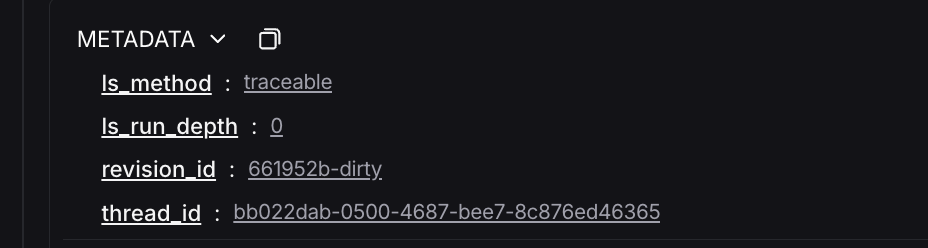

On clicking the thread button it takes us to thread view interface where we can see all the chat history with all of our associated traces linked with this thread id:

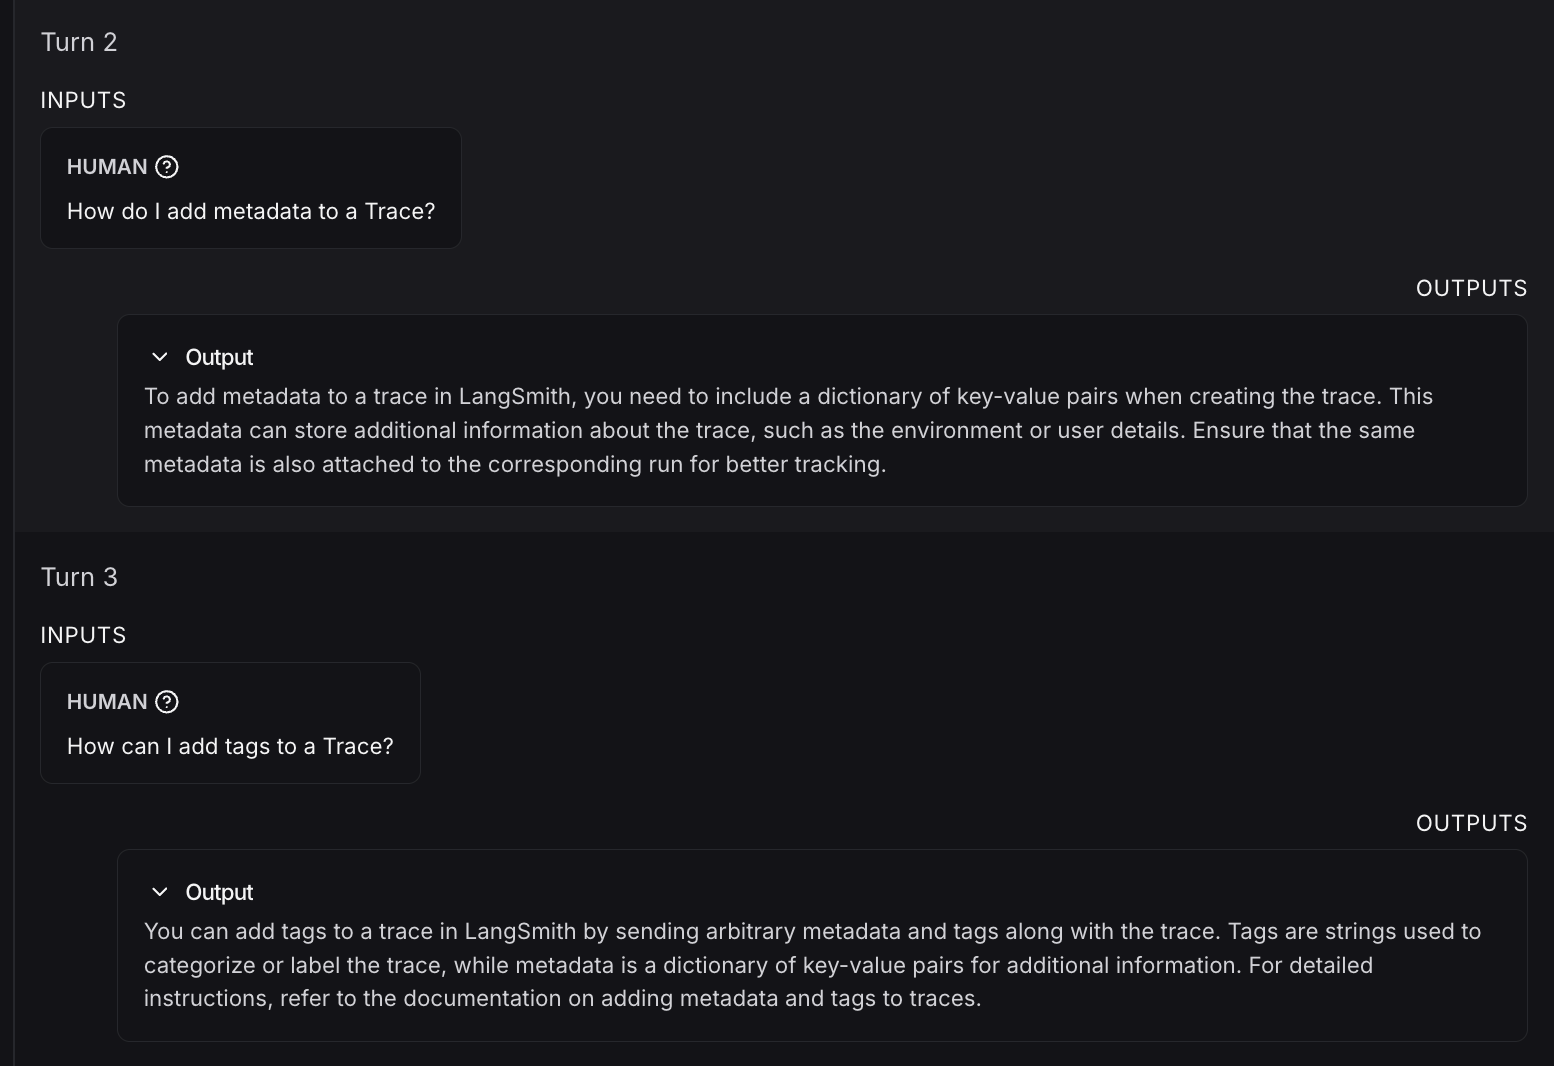

We can also see the number of tokens used and the average latency:

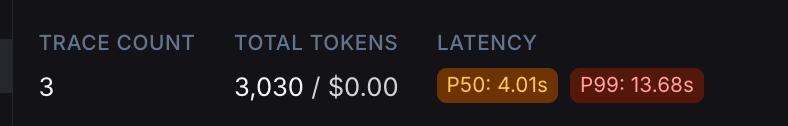

This view also helps us in entering each individual trace and analyse it:

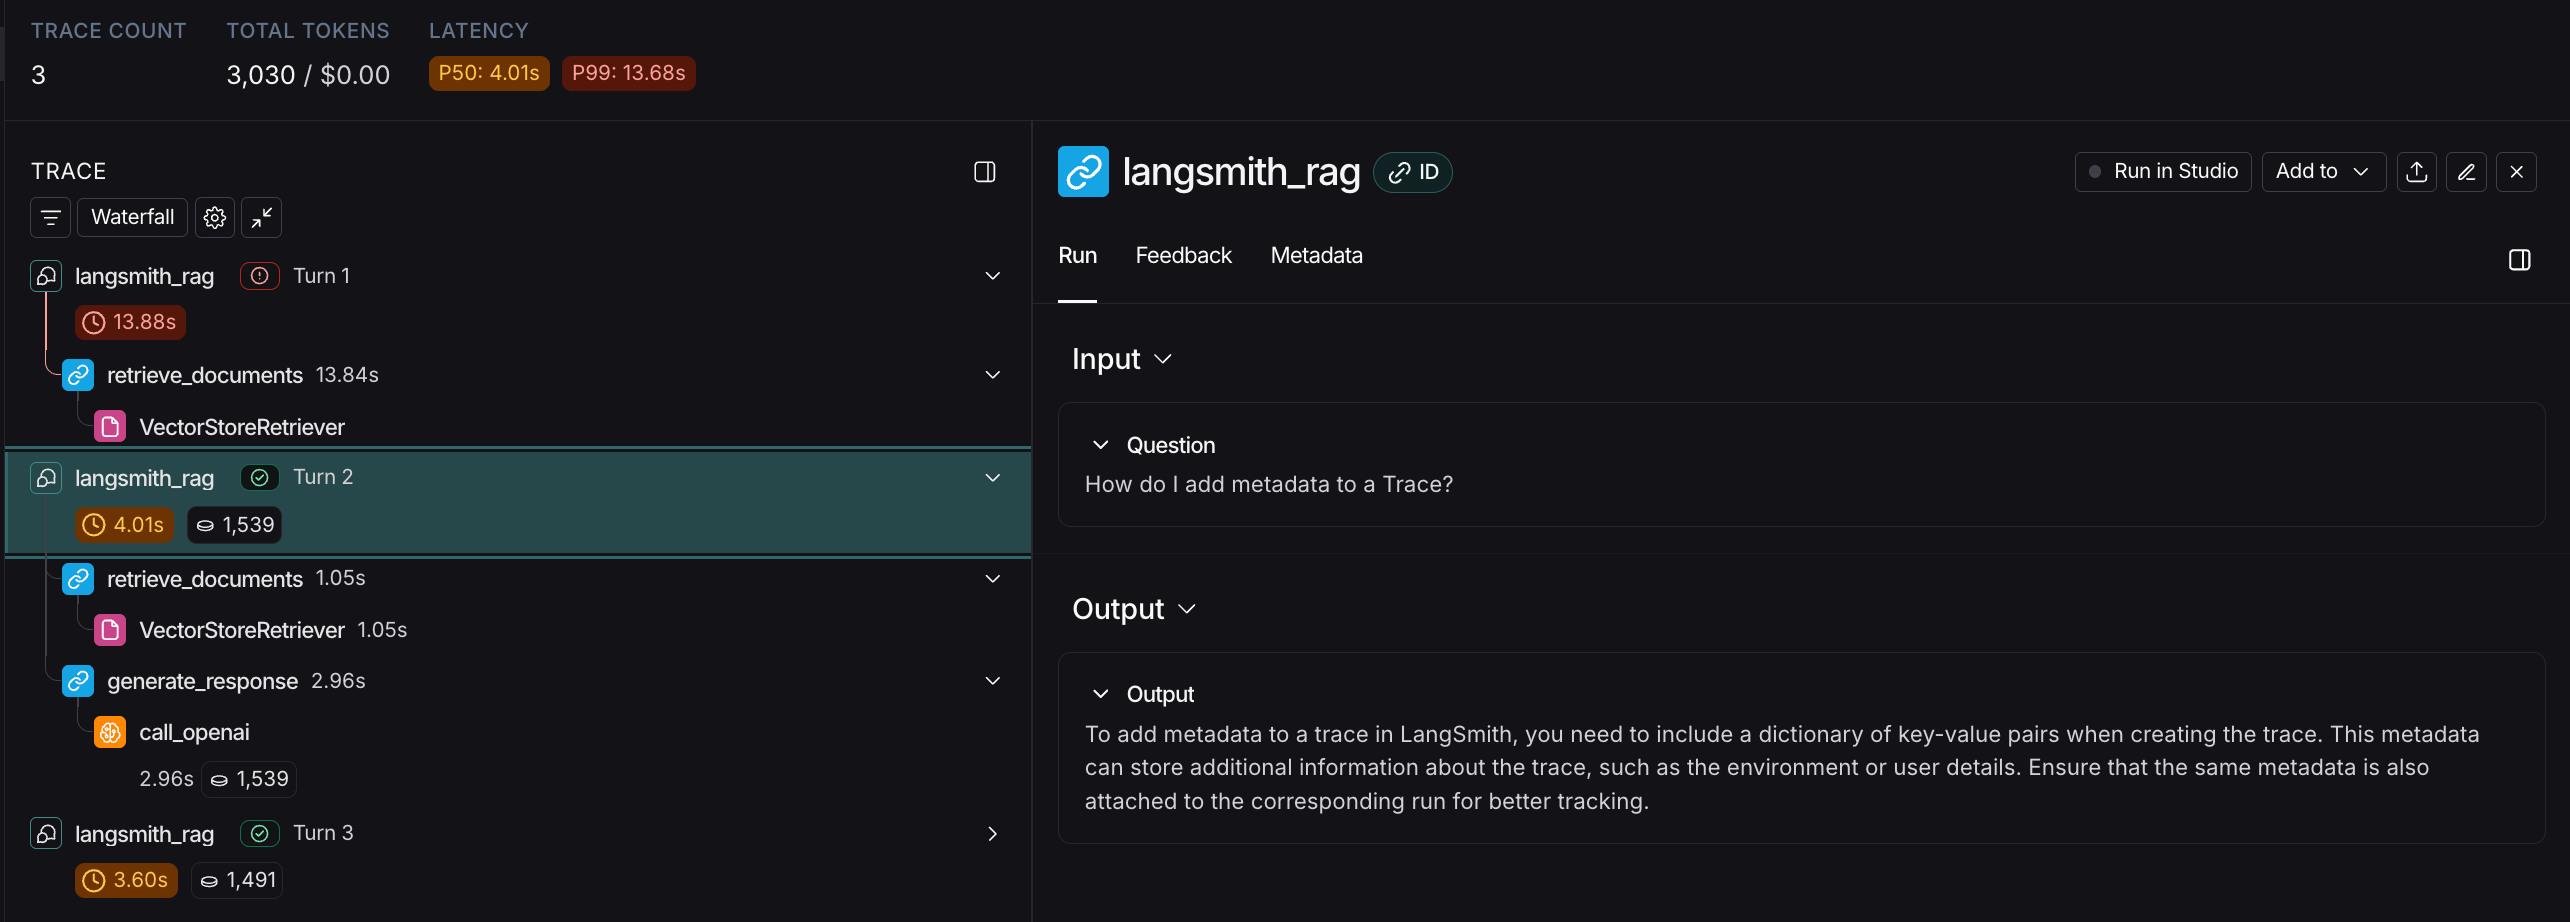

We can also filter all the threads linked to a particular thread id:

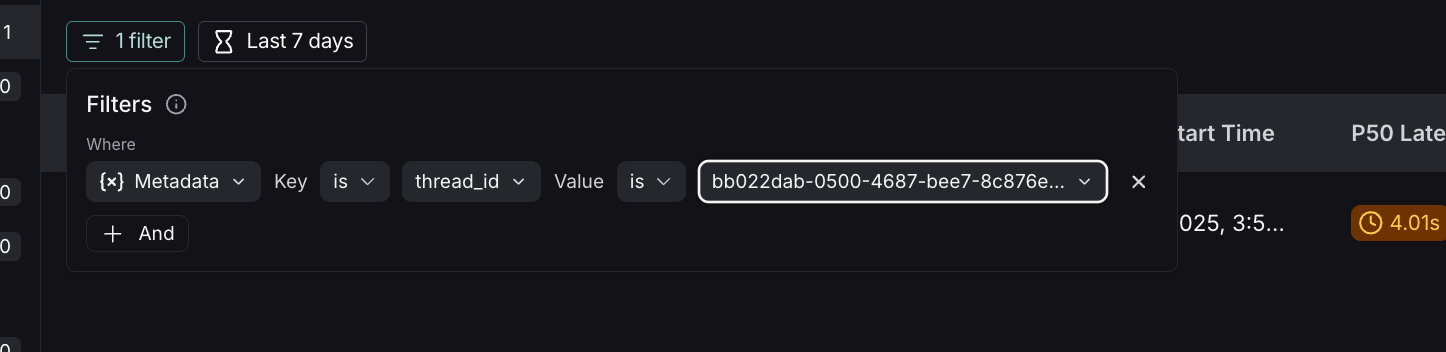